In [1]:
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
from scipy.interpolate import SmoothBivariateSpline
from scipy.stats import norm
from scipy.optimize import brentq
import matplotlib.pyplot as plt
from scipy.linalg import solve_banded
from scipy.optimize import minimize

In [2]:
def option_info(symbol, months=6, moneyness=0.2, liquidity=0.5, r=0.02, q=0):
    today = datetime.today().date()
    start_date = today + timedelta(days=30)
    end_date = today + timedelta(days=30 * months)

    ticker = yf.Ticker(symbol)
    expirations = ticker.options

    # Captures only options expires after 1 month and before 'x' months
    valid_dates = [
        date for date in expirations
        if start_date <= datetime.strptime(date, "%Y-%m-%d").date() <= end_date
    ]

    iv_dict = {}
    price_dict = {}
    filtered_dict = {}
    
    spot_price = ticker.history(period="1d")["Close"].iloc[-1]
      
    for date_str in valid_dates:
        exp_date = datetime.strptime(date_str, "%Y-%m-%d").date()
        T = (exp_date - today).days / 252

        opt_chain = ticker.option_chain(date_str)
        calls = opt_chain.calls
        calls = calls.copy()
        
        calls['midPrice'] = (calls['bid'] + calls['ask']) / 2
        price_dict[T] = dict(zip(calls['strike'].values, calls['midPrice'].values))
        iv_dict[T] = dict(zip(calls['strike'].values,calls['impliedVolatility'].values))
        
        forward_price = spot_price * np.exp((r-q)*T)
        lower_bound = forward_price * (1 - moneyness)
        upper_bound = forward_price * (1 + moneyness)
    
        filtered = calls[(calls['strike'] >= lower_bound) & (calls['strike'] <= upper_bound)]
        filtered = filtered.dropna(subset=['lastPrice', 'bid', 'ask', 'openInterest']) 
        if filtered.empty:
            continue
        
        # Liquidity score for better data
        filtered['liquidity'] = filtered['openInterest'] / (filtered['ask'] - filtered['bid'] + 1e-6)
        top_liquid = int(np.ceil(liquidity  * len(filtered)))
        filtered = filtered.sort_values(by='liquidity', ascending=False).head(top_liquid)
        
        filtered_dict[T] = np.array([filtered['strike'].values, filtered['impliedVolatility'].values])
    

    return iv_dict, price_dict, filtered_dict, spot_price

In [3]:
def svi_objective(params, S, K, T, r, q, iv):
    a, b, rho, m, sigma = params
    w = T * iv ** 2 
    
    forward = S * np.exp( (r-q) * T)
    k = np.log( K / forward )
    
    w_k = a + b * (rho * (k - m) + np.sqrt(sigma ** 2 + (k - m) ** 2))
    return np.sum((w_k - w) ** 2)


def svi_lv_fit(S, K, T, r, q, iv):
    
    init_params = [0.1, 0.1, -0.3, 0.0, 0.1] # a, b, rho, m, sigma
    bounds =  [
        (-1, 1),         # a
        (1e-5, 2),       # b
        (-0.999, 0.999), # rho
        (-2, 2),         # m
        (1e-5, 2)        # sigma
    ]
    
    result =  minimize(
            svi_objective,
            init_params,
            args=(S, K, T, r, q, iv),
            bounds=bounds,
            method='L-BFGS-B', 
            options={'disp': True, 'maxiter': 500}
        )
    
    return result.x

In [4]:
def svi_w(k, params):
    a, b, rho, m, sigma = params
    return a + b * (rho * (k - m) + np.sqrt((k - m)**2 + sigma**2))

def svi_w_k(k, params):
    a, b, rho, m, sigma = params
    denom = np.sqrt((k - m)**2 + sigma**2)
    return b * (rho + (k - m) / denom)

def svi_w_kk(k, params):
    a, b, rho, m, sigma = params
    denom = ((k - m)**2 + sigma**2)**1.5
    return b * sigma**2 / denom


def local_volatility(K, T, S, r, q, svi_params_dict):
    # Step 1: find two nearest T for finite difference
    T_list = sorted(svi_params_dict.keys())
    if T <= T_list[0]:
        T1, T2 = T_list[0], T_list[1]
    elif T >= T_list[-1]:
        T1, T2 = T_list[-2], T_list[-1]
    else:
        for i in range(len(T_list)-1):
            if T_list[i] <= T <= T_list[i+1]:
                T1, T2 = T_list[i], T_list[i+1]
                break

    params1 = svi_params_dict[T1]
    params2 = svi_params_dict[T2]

    F = S * np.exp((r - q) * T)
    k = np.log(K / F)

    w = svi_w(k, params1)
    wk = svi_w_k(k, params1)
    wkk = svi_w_kk(k, params1)
    wT = (svi_w(k, params2) - svi_w(k, params1)) / (T2 - T1)

    denom = 1 - (k / w) * wk + 0.25 * (wk / w)**2 + 0.5 * wkk
    sigma_sq = wT / denom
    
    return np.maximum(sigma_sq, 1e-2)



In [ ]:
# Pricing for single option with specific K and T
def Crank_Nicolson_Pricing(spot_price, T, K, r, q, sigma_sq, n_x=200, n_t=200, n_std = 3):  # n_x: steps for log S, n_t: steps for time
    # Set up grid
    x_0 = np.log(spot_price)
    # Prevent low local vol
    vol_range = max(n_std * np.sqrt(sigma_sq) * np.sqrt(T), 0.2)
    x_min = x_0 - vol_range
    x_max = x_0 + vol_range
    # print(np.exp(x_min), np.exp(x_max))
    dx = (x_max - x_min)/(n_x -1)
    # dx = max(dx, 1e-3)
    dt = T / n_t
    x = np.linspace(x_min, x_max, n_x)  
    t = np.linspace(0, T, n_t) 
    S = np.exp(x)
    
    # Initialize step-wise backwards solution
    u = np.maximum(S - K, 0)
    
    left_boundary = np.maximum(np.exp(x_min) - K * np.exp(-(r - q) * (T - t)), 0)
    right_boundary = np.maximum(np.exp(x_max) - K * np.exp(-(r - q) * (T - t)), 0)
    
    # Solve diagonal entries
    alpha = 0.5 * sigma_sq / (dx ** 2) + (r - q -0.5 * sigma_sq) / (2 * dx) # lower
    beta = -r - sigma_sq / (dx ** 2) # diagonal
    theta = 0.5 * sigma_sq / (dx ** 2) - (r - q - 0.5 * sigma_sq) / (2 * dx) # upper
    
    # Define L operator and its corresponding matrix, then derive matrix A & B in Crank Nicolson algorithm
    dt_L = (np.diag(beta * np.ones(n_x -2)) +  # diagonal
            np.diag(theta * np.ones(n_x -3), k=1) + # upper
            np.diag(alpha * np.ones(n_x -3), k=-1)) * dt/2 # lower
    A = np.diag(np.ones(n_x -2)) + dt_L
    B = A - 2 * dt_L
    ab_A = to_banded(A)

    # Compute u^n from Au^n = Bu^{n+1} + b 
    for index in range(len(t)):
        current = len(t) - 1 - index # index for u^{n+1}
        previous = current - 1 # # index for u^{n}
        b_0 = - dt/2 * alpha * (left_boundary[current] + left_boundary[previous]) # the boundary value of the 1st row 
        b_n = - dt/2 * theta * (right_boundary[current] + right_boundary[previous]) # the boundary value of the last row 
        b = np.zeros(n_x-2)
        b[0], b[-1] = b_0, b_n # construct boundary value array
        

        RHS = B @ u[1:-1] + b

    
        u_inner = solve_banded((1,1), ab_A, RHS)
        u = np.concatenate(([left_boundary[previous]], u_inner, [right_boundary[previous]]))
    
    if len(u) % 2 == 1:   
        return u[int(0.5 * (n_x - 1))] # Option value that corresponds to the current stock price
    else:
        return 0.5 * (u[int(0.5 * n_x)] + u[int(0.5 * n_x)+1])

# Transform A to solver required format
def to_banded(A):
    n = A.shape[0]
    ab = np.zeros((3, n))
    ab[0, 1:] = np.diag(A, k=1)
    ab[1, :]  = np.diag(A, k=0)
    ab[2, :-1]= np.diag(A, k=-1)
    return ab
      

In [46]:
def binomial_price(S, K, T, r, q, sigma, steps=100, option_type='call'):
    dt = T / steps
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp((r - q) * dt) - d) / (u - d)
    discount = np.exp(-r * dt)

    # Build stock price tree
    stock_tree = np.zeros((steps + 1, steps + 1))
    for i in range(steps + 1):
        for j in range(i + 1):
            stock_tree[j, i] = S * (u ** (i - j)) * (d ** j)

    # Build option value tree
    option_tree = np.zeros_like(stock_tree)

    # Terminal payoff
    for j in range(steps + 1):
        if option_type == 'call':
            option_tree[j, steps] = max(stock_tree[j, steps] - K, 0)
        else:
            option_tree[j, steps] = max(K - stock_tree[j, steps], 0)

    # Backward induction
    for i in reversed(range(steps)):
        for j in range(i + 1):
            cont_value = discount * (p * option_tree[j, i+1] + (1 - p) * option_tree[j+1, i+1])
            if option_type == 'call':
                intrinsic = max(stock_tree[j, i] - K, 0)
            else:
                intrinsic = max(K - stock_tree[j, i], 0)
            option_tree[j, i] = max(cont_value, intrinsic)

    return option_tree[0, 0]

def binomial_iv(S, K, T, r, q, market_price, option_type='call', steps=200):
    
    def objective(sigma):
        price = binomial_price(S, K, T, r, q, sigma, steps, option_type)
        return price - market_price

    try:
        implied_vol = brentq(objective, 1e-4, 3.0, maxiter=1000)
    except ValueError:
        implied_vol = np.nan  # No root found in range

    return implied_vol

In [ ]:
def test_robustness(symbol, test_T_index, months=6, moneyness=0.2, liquidity=0.5, rfr=0.02, dividend=0, indices=0, n_x=5, n_t=5, n_std = 3):
    iv_dict, price_dict, filtered_dict, spot_price = option_info(symbol, months=months, moneyness=moneyness, liquidity=liquidity, r=rfr, q=dividend)
    Ts = list(iv_dict.keys())
    
    test_T = Ts[test_T_index]
    test_strikes = list(price_dict[test_T].keys())
    test_market_prices = list(price_dict[test_T].values())
    test_iv = list(iv_dict[test_T].values())
    
    params = {}
    for T in Ts:
        params[T] = svi_lv_fit(spot_price, filtered_dict[T][0], T, rfr, dividend, filtered_dict[T][1])
    
    # IV_prices = []
    true_loc_vols = []
    true_LV_prices = []
    for strike in test_strikes:
        loc_vol = local_volatility(strike, test_T, spot_price, rfr, dividend, params)
        true_loc_vols.append(np.sqrt(loc_vol))
        true_LV_prices.append(Crank_Nicolson_Pricing(spot_price, test_T, strike, rfr, dividend, loc_vol, n_x=n_x, n_t=n_t, n_std = n_std))
        # IV_prices.append(Crank_Nicolson_Pricing(spot_price, test_T, strike, rfr, dividend, iv_dict[T][strike], n_x=n_x, n_t=n_t, n_std = n_std))
        
    del params[test_T]
    fitted_loc_vols = []
    fitted_LV_prices = []
    for strike in test_strikes:
        loc_vol = local_volatility(strike, test_T, spot_price, rfr, dividend, params)
        fitted_loc_vols.append(np.sqrt(loc_vol))
        fitted_LV_prices.append(Crank_Nicolson_Pricing(spot_price, test_T, strike, rfr, dividend, loc_vol, n_x=n_x, n_t=n_t, n_std = n_std))

    '''
    binomial_vols = []
    binomial_LV_prices = []
    for strike in test_strikes:
        binomial_vol = binomial_iv(spot_price, strike, test_T, rfr, dividend, price_dict[test_T][strike])
        binomial_vols.append(binomial_vol)
        binomial_LV_prices.append(Crank_Nicolson_Pricing(spot_price, test_T, strike, rfr, dividend, binomial_vol, n_x=n_x, n_t=n_t, n_std = n_std))
    '''   
    
    fig, axs = plt.subplots(2, 1, figsize=(8, 10)) 
    axs[0].plot(test_strikes[indices:], test_market_prices[indices:], label='Market prices')
    axs[0].plot(test_strikes[indices:], true_LV_prices[indices:], label='True LV prices')
    axs[0].plot(test_strikes[indices:], fitted_LV_prices[indices:], label='Fitted LV prices')
    # axs[0].plot(test_strikes[indices:], IV_prices[indices:], label='IV prices')
    # axs[0].plot(test_strikes[indices:], binomial_LV_prices[indices:], label='Binomial LV prices')
    axs[0].axvline(x=spot_price, color='red', linestyle='--', label='Spot price')
    axs[0].set_xlabel('Strike')
    axs[0].set_ylabel('Option Price')
    axs[0].set_title(f'{symbol} Call, expires in {test_T*252} days')
    axs[0].legend()
    axs[0].grid(True)   
    
    axs[1].plot(test_strikes[indices:], test_iv[indices:], label='Implied Volatility', linestyle='--')
    axs[1].plot(test_strikes[indices:], true_loc_vols[indices:], label='True Local Vol')
    axs[1].plot(test_strikes[indices:], fitted_loc_vols[indices:], label='Fitted Local Vol')
    # axs[1].plot(test_strikes[indices:], binomial_vols[indices:], label='Binomial Derived Volatility', linestyle='--')
    axs[1].axvline(x=spot_price, color='red', linestyle='--', label='Spot price')
    axs[1].set_xlabel('Strike')
    axs[1].set_ylabel('Volatility')
    axs[1].set_title(f'{symbol} Volatility Comparison, T = {round(test_T*252)} days')
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

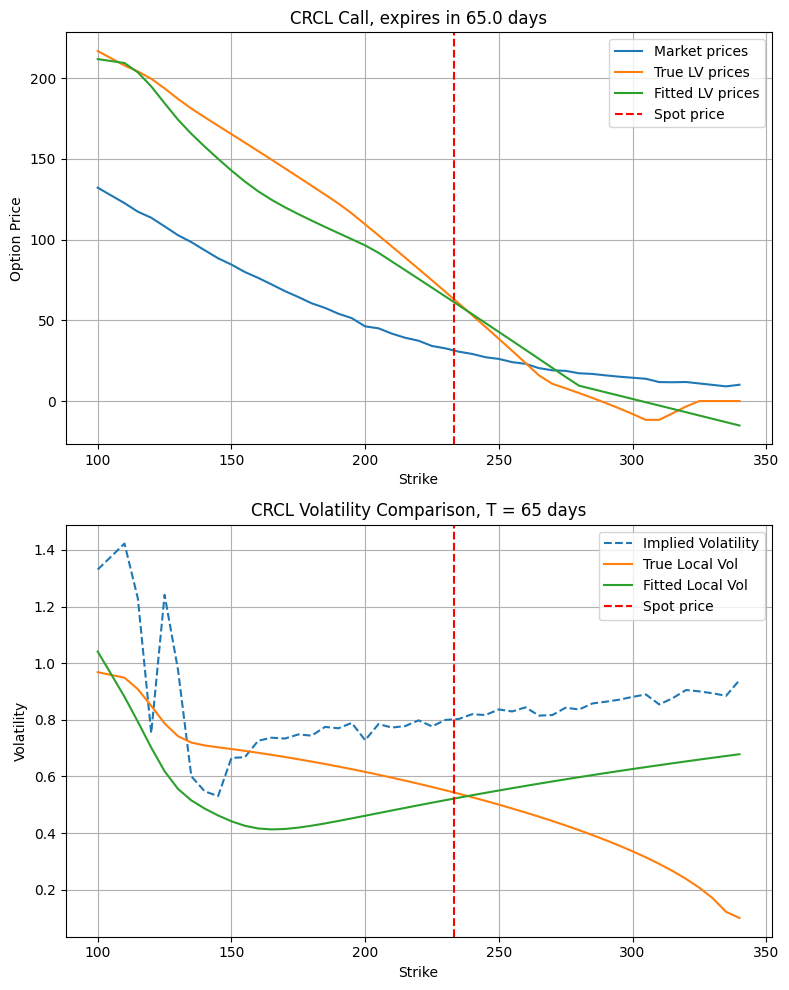

In [65]:
test_robustness('CRCL', 3, indices=0, n_x=6, n_t=200)

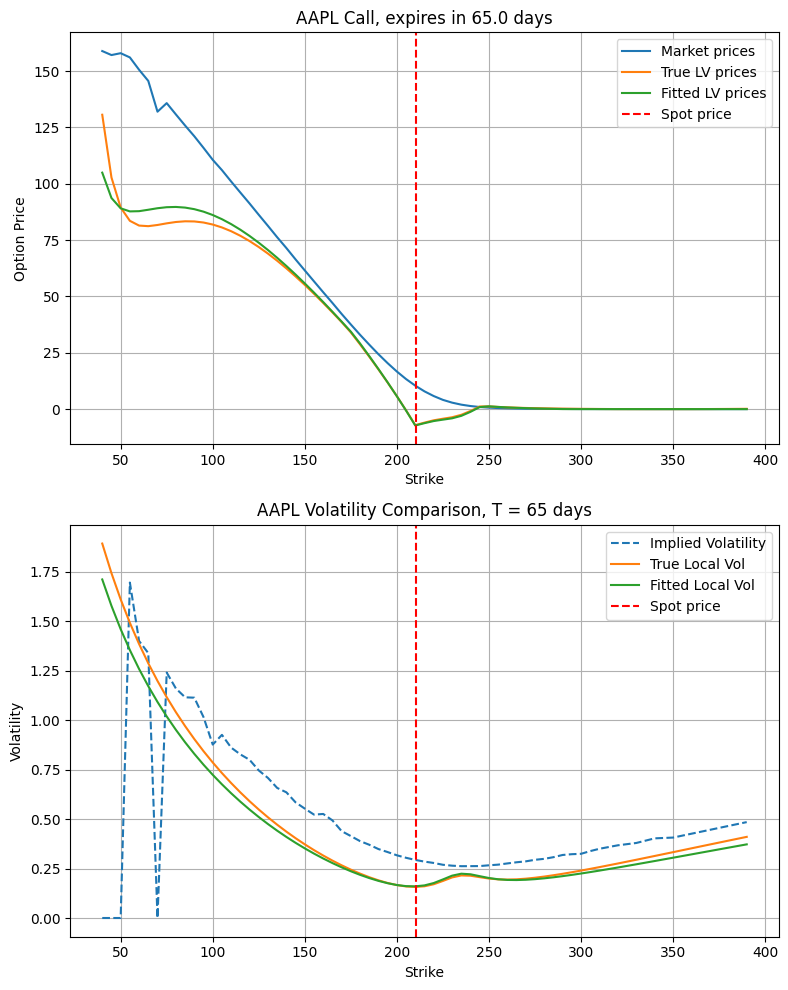

In [ ]:
test_robustness('AAPL', 3, indices=7)

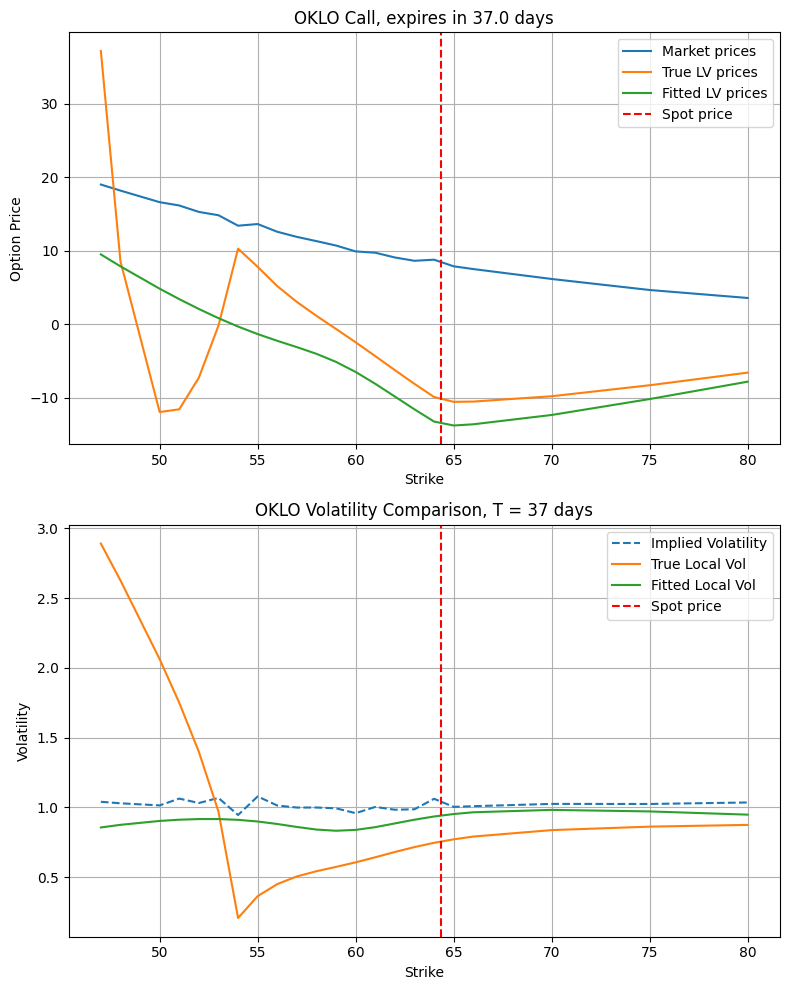

In [67]:
test_robustness('OKLO', 1, indices=5)

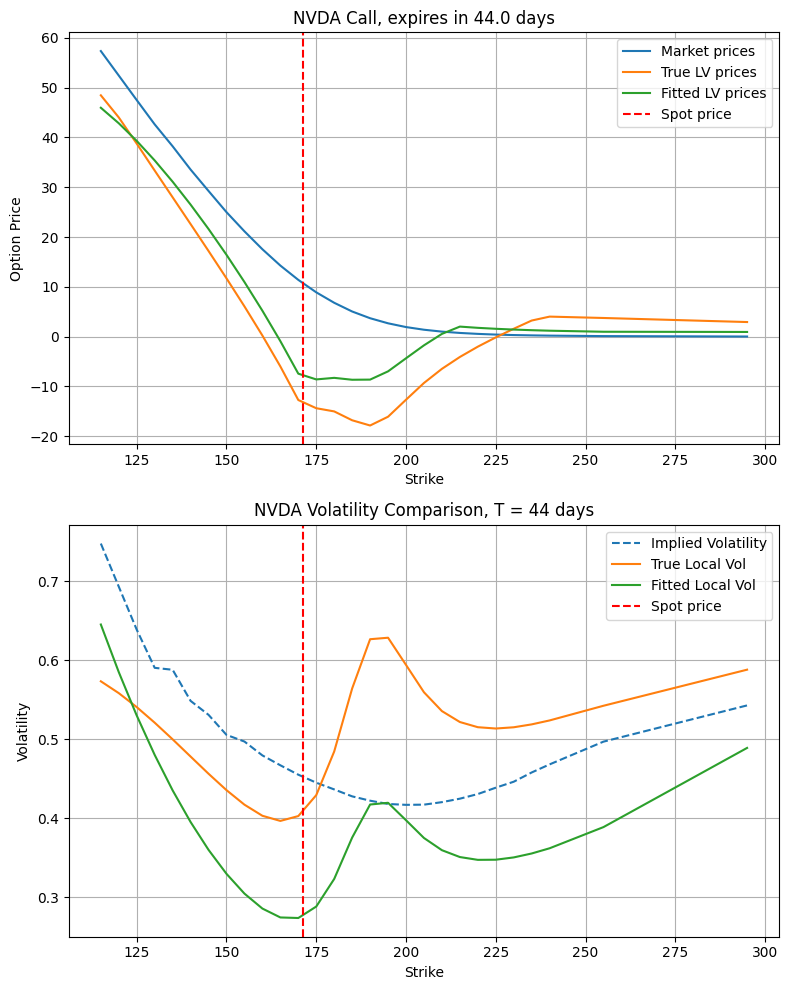

In [21]:
test_robustness('NVDA',2)

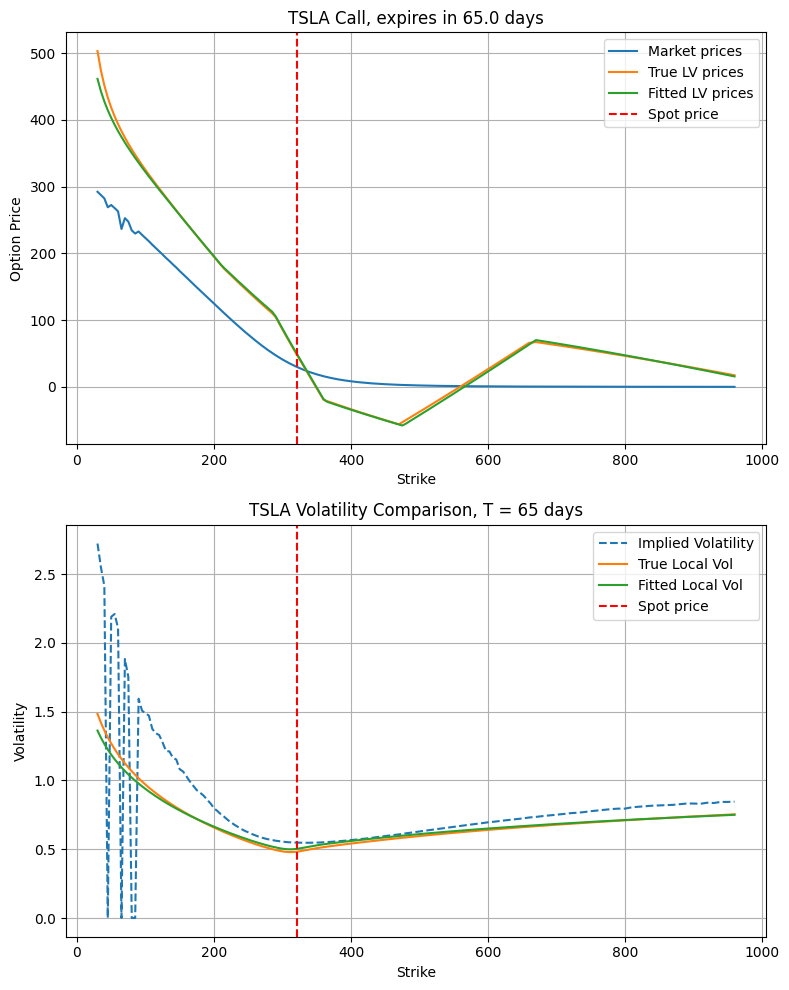

In [68]:
test_robustness('TSLA', 3, indices=5, n_x=8, n_t=100, n_std=3)